# Поиск нарушений на видео с помощью компьютерного зрения

Автоматизация обработки нарушений на видеозаписях - одно из востребованных направлений компьютерного зрения во многих отраслях.  
Сегодня мы попытаемся обнаружить на видео отсутствие клиента в кадре в момент проведения операции в автоматизированной системе. В нашем распоряжении имеются записи с камер наблюдения рабочего места сотрудника и журнал проведения операций. 

Будем искать все моменты на записи, где отсутствовал клиент. В этом нам поможет нейронная сеть MobileNet и CSRT Tracker из библиотеки **opencv**. А для удобства еще и Tesseract-OCR.

Чтобы найти человека в кадре будем использовать нейросеть MobileNet. Данная сеть позволяет обнаружить и локализовать 20 типов объектов на изображении. Для ее работы необходимо скачать два файла: архитектуру и веса. Данные файлы можно найти в репозитории Github.

Перед написанием кода нам понадобится установка библиотеки компьютерного зрения **cv2** и пакета для обработки текста на изображениях **pytesseract**.   

In [ ]:
!pip install opencv-python
!pip install pytesseract

Для работы pytesseract необходимо предварительно скачать дистрибутив Tesseract-OCR c официального сайта и установить его.

## Начинаем подготовку к обработке видео
Импортируем пакеты и прописываем в локальное окружение путь к папке с Tesseract-OCR: 


In [ ]:
import os

video_path = ... #Путь к видео
tesseract_path = ... #Путь к установленному Tesseract
os.environ["PATH"] += os.pathsep + tesseract_path

import pytesseract
import cv2
import imutils
import pandas as pd
import datetime as dt

Затем создаем таблицу, где будем хранить информацию о каждом обработанном кадре видео. Вместе с таблицей создаем еще три переменные для хранения информации о границах места клиента, времени и наличия / отсутствия клиента в кадре:

In [ ]:
df = pd.DataFrame(columns = ['Время', 'Клиент в кадре'])
work_place = () #Область, где сидит клиент
date = None #Область на видео с временем и датой
tracked = False #Состояние отслеживания

Укажем пути к файлам с архитектурой и весами нейронной сети, которые мы скачали ранее. Если они лежат в папке с проектом, то просто запишем их названия:

In [ ]:
prototxt = 'MobileNetSSD_deploy.prototxt' #Модель
weights = 'MobileNetSSD_deploy.caffemodel' #Веса

Как сказано выше данная нейросеть может различать 20 классов объектов, запишем их в словарь:

In [ ]:
classNames = {0: 'background',
              1: 'aeroplane',
              2: 'bicycle',
              3: 'bird',
              4: 'boat',
              5: 'bottle',
              6: 'bus',
              7: 'car',
              8: 'cat',
              9: 'chair',
              10: 'cow',
              11: 'diningtable',
              12: 'dog',
              13: 'horse',
              14: 'motorbike',
              15: 'person',
              16: 'pottedplant',
              17: 'sheep',
              18: 'sofa',
              19: 'train',
              20: 'tvmonitor'}

Выставим уровень доверия низким, так как шанс ошибиться и классифицировать другой объект на рабочем месте как человека крайне низкий.

In [ ]:
thr = 0.1 #Уровень доверия

Инициализируем нейронную сеть:

In [ ]:
net = cv2.dnn.readNetFromCaffe(prototxt, weights) #Нейросеть

Создадим объект cv2.VideoCapture, с помощью которого мы будем воспроизводить видео:

In [ ]:
cap = cv2.VideoCapture(video_path)

Заявленная частота кадров в секунду в видео может отличаться от действительной, поскольку метод **.read()**, которым мы вскоре воспользуемся может пропускать некоторые кадры. Так как нас интересует точное время с камеры наблюдения, мы должны знать сколько кадров помещается в одной секунде из видео. Для этого необходимо узнать общее количество кадров в записи и разделить его на его длительность. Выполним следующий код:

In [ ]:
%%time

cap = cv2.VideoCapture(video_path)

total_frame = 0
while True:
    success, frame = cap.read()
    if success:
        total_frame += 1
    else:
        break
        

video_length = ... #Длительность видео в секундах
fps = round(total_frame / video_length)
fps

Так как количество кадров в секунду может быть не целым числом, то возможна погрешность. В 100-минутном ролике погрешность составляла 2 секунды.   

## Обработка видео

Узнав действительную частоту кадров, мы, наконец, можем приступить к непосредственной обработке нашего видео.
Запускаем цикл, который будет работать до тех пор, пока не закончатся кадры.

In [ ]:
while cap.isOpened():

    ret, frame = cap.read()
    
    if ret:
        
        frame = imutils.resize(frame, width=1200) #Качество кадра, влияет на быстродействие


        #Получение участка кадра, где расположено рабочее место
        if len(work_place) == 0:
            cv2.putText(frame, 'Set the working place', (0, 90), cv2.FONT_HERSHEY_SIMPLEX, 
                2, (0,255,0), 2)
            work_place = cv2.selectROI('frame', frame, fromCenter=False, showCrosshair=True)
            x, y, w, h = [int(coord) for coord in work_place]
            
        #Получение даты
        if not date:
            try:
                cv2.putText(frame, 'Set the client\'s location', (0, 160), cv2.FONT_HERSHEY_SIMPLEX, 
                    2, (0,255,0), 2)
                date = cv2.selectROI('frame', frame, fromCenter=False, showCrosshair=True)
                date_x, date_y, date_w, date_h = [int(coord) for coord in date]
                date_ = frame[date_y : date_y+date_h, date_x : date_x+date_w]
                date_ = cv2.cvtColor(date_, cv2.COLOR_BGR2GRAY) #Приводим к градации серого
                #date_ = cv2.threshold(date_, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
                date_ = cv2.threshold(date_, 180, 255, 0)[1] #Можно менять значения для лучшего распознавания
                date = pytesseract.image_to_string(date_)
                date = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
                
            except:
                print('Распознать дату не удалось, введите дату вручную в формате ГОД-МЕСЯЦ-ДЕНЬ ЧАСЫ:МИНУТЫ:СЕКУНДЫ')
                date_ = input()
                date = dt.datetime.strptime(date_, '%Y-%m-%d %H:%M:%S')
                

        if cap.get(1) % fps == 0:
            date += dt.timedelta(seconds = 1)
        
        if not tracked or (cap.get(1) % (fps * 30) == 0):

            #Предобработка кадра
            frame_resized = cv2.resize(frame, (300, 300)) #Подгон изображения под 300 на 300 пикс
            blob = cv2.dnn.blobFromImage(frame_resized, 0.007843, 
                                         (300,300), (127.5, 127.5, 127.5), False)

            #Прямой проход кадра по нейросети
            net.setInput(blob)
            detections = net.forward() 
            #[0, 0, object, [0, class_id, confidence, xLeftBottom, yLeftBottom, xRightTop, yRightTop]]

            #Запоминаем размеры предобработанного кадра
            cols = frame_resized.shape[1]
            rows = frame_resized.shape[0]

            #Детекция класса и получение его рамки исходных размеров
            for obj in detections[0,0, :, :]:
                confidence = obj[2]
                if confidence > thr:

                    class_id = int(obj[1])
                    if class_id == 15:

                        xLeftBottom = int(obj[3] * cols)
                        yLeftBottom = int(obj[4] * rows)
                        xRightTop   = int(obj[5] * cols)
                        yRightTop   = int(obj[6] * rows)

                        #Отношения размеров оригинального и сжатого кадра
                        heightFactor = frame.shape[0] / 300.0
                        widthFactor = frame.shape[1] / 300.0

                        #Границы объекта на несжатом кадре
                        xLeftBottom = int(widthFactor * xLeftBottom)
                        yLeftBottom = int(heightFactor * yLeftBottom)
                        xRightTop   = int(widthFactor * xRightTop)
                        yRightTop   = int(heightFactor * yRightTop)

                        #Нахождения центра рамки границы объекта
                        xCenter = xLeftBottom + (xRightTop - xLeftBottom)/2
                        yCenter = yLeftBottom + (yRightTop - yLeftBottom)/2

                        #Проверка вхождения объекта в выделенную область
                        if xCenter < x + w and yCenter < y + h and xCenter > x and yCenter > y:
                            tracker = cv2.TrackerCSRT_create()
                            tracker.init(frame, (xLeftBottom, yLeftBottom, xRightTop-xLeftBottom, yRightTop-yLeftBottom))
                            tracked = True
                            cv2.rectangle(frame, (xLeftBottom,yLeftBottom), (xRightTop,yRightTop), (0,255,0), 3, 1)
                            break
                        else:
                            tracked = False
        else:
            _, bbox = tracker.update(frame)
            X, Y, W, H = [int(coord) for coord in bbox]

            xCenter = X + W/2
            yCenter = Y + H/2
            
            if xCenter < x + w and yCenter < y + h and xCenter > x and yCenter > y:
                
                tracked = True
                cv2.rectangle(frame, (X,Y), (X + W, Y + H), (255,255,0), 3, 1)
            else:
                tracked = False

        cv2.imshow('frame', frame)
        df.loc[cap.get(1), :] = [date, tracked]
        print(cap.get(1), date, tracked) #Вывод номера кадра, даты и наличия/отсутствия клиента
        if cv2.waitKey(1) == 27: #ESC
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

Метод **.read()** возвращает нам два значения: логическую переменную, обозначающую успешное чтение кадра, и второе значение – сам кадр.  

Далее мы проверяем, указано ли место клиента, если нет, то нам предлагается обвести прямоугольную область.  

Затем мы таким же образом обводим дату в кадре. Как правило, дата представлена в формате *«год-месяц-день часы:минуты:секунды»*. Выделенная область приводится к оттенкам серого, а затем пиксели разбиваются на два цвета: черный и белый, в зависимости от насыщенности оттенка серого. Результат записывается в переменную `date`.


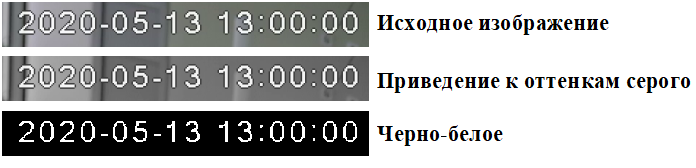

В таком виде *Tesseract*-у проще сделать оптическое распознавание символов  
Если оптическое распознавание не удалось, то пользователю предлагается ввести дату вручную. Как правило, распознавание не удается, если на фоне даты находятся участки такого же цвета.  

Метод **.get()** с цифрой 1 возвращает номер текущего кадра, и, если он кратен вычисленному нами ранее `fps` из видео, то прибавляем к нашему времени в переменной `date` одну секунду. Мы могли в каждом кадре распознавать дату с помощью tesseract, но тогда наша обработка затянулась бы на дни, так как оптическое распознавание очень ресурсоемкий процесс.

Далее мы предобрабатываем кадр для прогона его через нейросеть: масштабируем с помощью метода **cv2.resize()** и изменяем цвет пикселей методом **cv2.dnn.blobFromImage()**.
После чего, мы подаем предобработанный кадр в нейросеть. Обратно мы получаем предсказание, которое мы запишем в переменную `detections`. В ней будут содержаться сведения о найденных объектах, вероятности их отнесения к одному из 20 классов и координаты местоположения в кадре.  

Поскольку нас интересует только человек, мы ищем все объекты с индексом 15. Если вероятность нахождения человека в кадре выше нашего доверительного уровня, и человек находится в пределах выделенного места, то мы присваиваем переменной `tracked` значение *True* и передаем найденные координаты трекеру. Результаты `tracked` и переменной `date` записываем в таблицу `df`.  

После этого трекер начинает отслеживать клиента до тех пор, пока тот не выйдет из выделенной области. Как только клиент покидает область, переменная `tracked` меняется с *True* на *False*, и включается нейросеть для поиска следующего клиента.  

Трекер необходим для уменьшения количества ошибок. Так как нейросеть не предназначалась для решения конкретно этой проблемы, то сидящих спиной клиентов, она распознает не в каждом кадре. Трекер частично решает проблему. 

В конце мы получим таблицу, где для каждого кадра записано время и наличие / отсутствие клиента в выделенной области. Сгруппируем ее по секундам и будем считать, что если хотя бы в одном кадре за секунду есть клиент, то он там действительно есть.  


In [ ]:
df_ = df.groupby('Время', as_index=False).agg(max)
df_.to_excel('output.xlsx', index=False)


## Недостатки:
* **Медленная работа трекера**. Мы используем трекер, основанный на корреляционных фильтрах. Это один из реализованных  трекеров в библиотеке opencv. Он обладает хорошей точностью, относительно других трекеров из библиотеки, но является самым медленным.
* **Трекер может потерять из виду объект**. При резких движениях или окклюзии трекер может потерять или начать отслеживать совершенно другой объект.
* **Низкая способность нейросети обнаруживать клиента**. Нейросеть не всегда распознает сидячих клиентов, особенно, если они находятся спиной к камере. Поэтому важно «обнаружить» клиента, пока он стоит в полный рост. 

Решить первую и вторую проблему могут трекеры, основанные на глубоком обучении. Например, трекер `GOTURN`. Данный трекер реализован в библиотеке `opencv`, но для его работы необходимо скачивать дополнительные файлы. Также можно использовать популярный трекер `Re3` или недавно представленный трекер `AcurusTrack`. Третью проблему можно решить заменой нейросети и/или дообучением ее на сидящих людях.
